In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:
pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [28]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix


# PREPARE THE DATA

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier

In [31]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [32]:
import splitfolders
splitfolders.ratio("/kaggle/input/acrima-cnn/Acrima", output="./", seed=1337, ratio=(.65, .2, .15), group_prefix=None) # default values

Copying files: 6000 files [00:27, 220.92 files/s]


In [33]:
train_path="./train"             #Just copy the link of the train image path
test_path="./test"               #Just copy the link of the test image path
val_path="./val"               #Just copy the link of the validation image path

In [34]:
x_train=[] # Empty list of x_train
for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))
    
        x_train.append(img_arr)
x_test=[]  # Empty list of x_test

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_test.append(img_arr)
x_val=[]   # Empty list of nx_val

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)

In [35]:
x_train=np.array(x_train)
x_test=np.array(x_test)
x_val=np.array(x_val)

In [36]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

train_generator=train_datagen.flow_from_directory(train_path, 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=8,
                                                 class_mode='binary',
                                                 shuffle=True)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

val_generator=val_datagen.flow_from_directory(val_path, 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=8,
                                                 class_mode='binary',
                                                 shuffle=True)
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
                                            test_path, 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=8,
                                                 class_mode='binary',
                                                 shuffle=True)

Found 3900 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


In [37]:
y_train=train_generator.classes
y_test=test_generator.classes
y_val=val_generator.classes

In [38]:
num_classes = 2
input_shape = (224, 224, 3)

targetnames = ['Glaucoma',
 'Normal']
num_classes = 2

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")


x_train shape: (3900, 224, 224, 3) - y_train shape: (3900,)
x_test shape: (900, 224, 224, 3) - y_test shape: (900,)
x_val shape: (1200, 224, 224, 3) - y_val shape: (1200,)


# configure parameters

In [39]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 40
image_size = 72 
patch_size = 4  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
mlp_head_units = [2048, 1024] 


# USE DATA AUGMENTATION

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)


# IMPLEMENT MLP

In [41]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# implement patch creation as a layer

In [42]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 4 X 4
Patches per image: 324
Elements per patch: 48


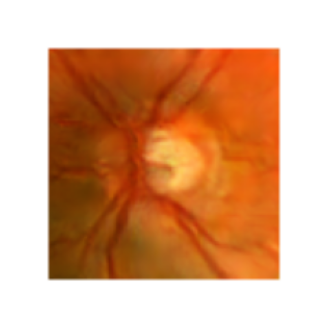

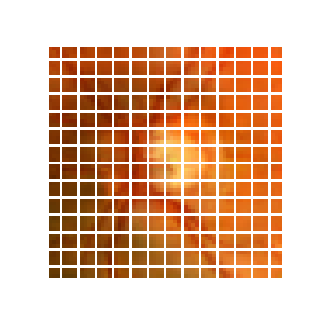

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image.astype("uint8"))

plt.axis("off")
plt.savefig("glaucoma.png")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
plt.savefig("patches.png")

# implement the patch encoding layer

In [43]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Channel Attention layer

In [45]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Reshape, Multiply

def channel_attention(input_tensor, reduction_ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_tensor.shape[channel_axis]
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    avg_pool = GlobalAveragePooling1D(data_format="channels_last" if channel_axis == -1 else "channels_first")(input_tensor)
    avg_pool = Reshape((1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    if channel_axis == -1:
        return Multiply()([input_tensor, avg_pool])
    else:
        return Multiply()([input_tensor, avg_pool])

# build the ViT model

In [46]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    
    
    efficientnet = tf.keras.applications.EfficientNetB7(input_shape=input_shape, include_top=False, weights='imagenet')(inputs)
    
    #create patches
    patches = Patches(patch_size)(efficientnet)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Apply channel attention to x1 before self-attention
        x1_with_channel_attention = channel_attention(x1)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1_with_channel_attention,x1_with_channel_attention)
        
        
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model


# compile, train & evaluate the model

In [47]:
from tensorflow.keras.utils import to_categorical
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
        
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/40


2023-09-12 06:54:52.221440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/multi_head_attention_18/dropout/dropout/GreaterEqual' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_28/4001224.py", line 42, in <module>
      history = run_experiment(vit_classifier)
    File "/tmp/ipykernel_28/4001224.py", line 22, in run_experiment
      history = model.fit(
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/attention/multi_head_attention.py", line 598, in call
      attention_output, attention_scores = self._compute_attention(
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/attention/multi_head_attention.py", line 535, in _compute_attention
      attention_scores_dropout = self._dropout_layer(
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/regularization/dropout.py", line 120, in call
      output = control_flow_util.smart_cond(
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/regularization/dropout.py", line 116, in dropped_inputs
      return self._random_generator.dropout(
    File "/opt/conda/lib/python3.10/site-packages/keras/backend.py", line 2171, in dropout
      return tf.nn.dropout(
Node: 'model_2/multi_head_attention_18/dropout/dropout/GreaterEqual'
failed to allocate memory
	 [[{{node model_2/multi_head_attention_18/dropout/dropout/GreaterEqual}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_308916]

In [24]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 72, 72, 32)   896         ['data_augmentation[0][0]']      
                                                                                                  
 conv2d_1 (Conv2D)              (None, 72, 72, 64)   18496       ['conv2d[0][0]']             

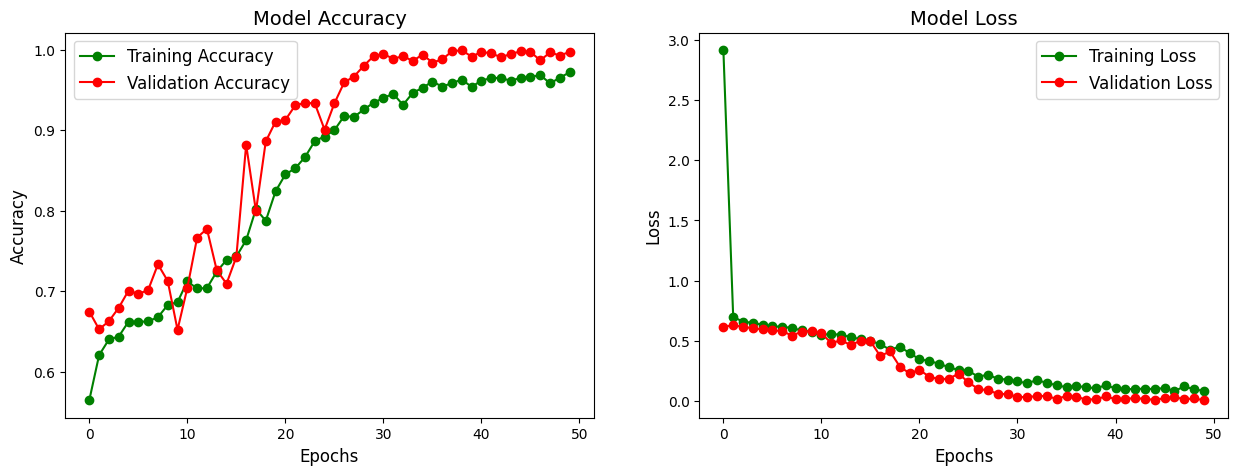

In [31]:
import matplotlib.pyplot as plt
epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
ax[0].set_title('Model Accuracy', fontdict=title_font)
legend_font = {'family': 'Times New Roman', 'size': '12', 'weight': 'normal'}
ax[0].legend(prop=legend_font)
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}
ax[0].set_xlabel("Epochs",  fontdict=label_font)
ax[0].set_ylabel("Accuracy",  fontdict=label_font)

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Model Loss', fontdict=title_font)
ax[1].legend(prop=legend_font)
ax[1].set_xlabel("Epochs", fontdict=label_font)
ax[1].set_ylabel("Loss", fontdict=label_font)
plt.savefig("accuracy.png")
plt.show()

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


## GradCam & Heatmap Representation

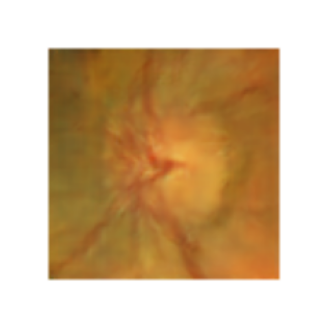

In [33]:
plt.figure(figsize=(4, 4))
#image = x_train[np.random.choice(range(x_train.shape[0]))]
img_path = "/kaggle/input/acrima-dataset/Acrima/Glaucoma/train-27040.png"
image = keras.preprocessing.image.load_img(img_path)
image = keras.preprocessing.image.img_to_array(image)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(224,224))
plt.imshow(image.astype("uint8"))
plt.savefig("glaucoma.jpg")
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)


In [34]:
def get_img_array(img):
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [35]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
        
    
    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 38ms/step
Predicted:
No glaucoma:     7.261720657348633
glaucoma: -7.36084508895874


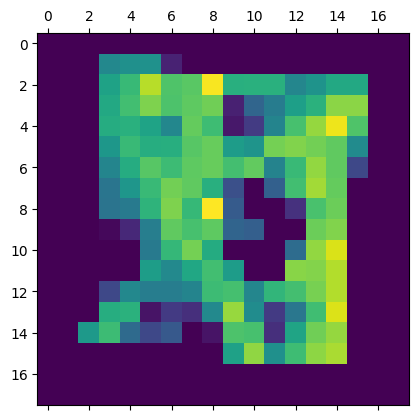

In [38]:
from PIL import Image


img_array = get_img_array(image)

last_conv_layer_name = 'layer_normalization_33'

vit_classifier.layers[-1].activation = None

preds = vit_classifier.predict(img_array)
print("Predicted:\n" + "No glaucoma: \
    {p1}\nglaucoma: {p2}".format(p1=preds[0][0], p2=preds[0][1]))

heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

heatmap = np.reshape(heatmap, (18,18))

plt.matshow(heatmap)
plt.savefig("heatmap.jpg")

plt.show()

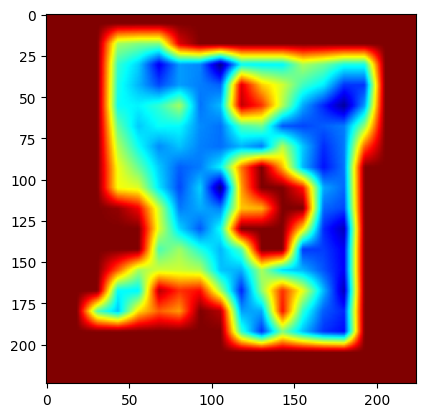

In [39]:
def save_and_display_gradcam(img, heatmap):

  
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap 


    cv2.imwrite('grad.jpg', superimposed_img)

    plt.imshow(superimposed_img)
    plt.show()
save_and_display_gradcam(image, heatmap)


In [26]:
pip install tf-keras-vis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Feature Extraction

In [56]:
# Extract features using the trained Vision Transformer model
from tensorflow.keras.models import Model
feature_extractor = Model(inputs=vit_classifier.input, outputs=vit_classifier.layers[-1].output)

x_train_features = feature_extractor.predict(x_train)
x_val_features = feature_extractor.predict(x_val)
x_train = np.concatenate((x_train_features, x_val_features))
x_test = feature_extractor.predict(x_test)
X = np.concatenate((x_train,x_test))

y_train = np.concatenate((y_train, y_val))
Y = np.concatenate((y_train,y_test))


19/19 [==============================] - 1s 38ms/step


In [57]:
def cvresult(y,pred):
  print('Cross Val f1 score : ',f1_score(y,pred))
  print('Cross Val Precision : ',precision_score(y,pred))
  print('Cross Val recall : ',recall_score(y,pred))
  print('MCC : ',matthews_corrcoef(y,pred))
  print('Cohen Kappa score : ',cohen_kappa_score(y,pred))
  print('Cross Val Classification Report : \n',classification_report(y,pred))

In [58]:
def result(y,p):
  print('Accuracy : ',accuracy_score(y,p))
  print('f1 score : ',f1_score(y,p))
  print('Precision : ',precision_score(y,p))
  print('recall : ',recall_score(y,p))
  print('MCC : ',matthews_corrcoef(y,p))
  print('Cohen Kappa score : ',cohen_kappa_score(y,p))
  print('Classification Report : \n',classification_report(y,p))

# # LR

In [59]:
 import time

start_time = time.time()

# Your code goes here
lrclassifier = LogisticRegression()
lrclassifier.fit(x_train,y_train)

end_time = time.time()

print("Execution time:", end_time - start_time, "seconds")

Execution time: 0.07189393043518066 seconds


In [60]:
Y_predlr = lrclassifier.predict(x_test)
Y_cvpredlr = cross_val_predict(lrclassifier, X, Y, cv=10)
result(y_test,Y_predlr)

Accuracy :  1.0
f1 score :  1.0
Precision :  1.0
recall :  1.0
MCC :  1.0
Cohen Kappa score :  1.0
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [61]:
cvresult(Y,Y_cvpredlr) #10 fold

Cross Val f1 score :  0.9998333055509252
Cross Val Precision :  1.0
Cross Val recall :  0.9996666666666667
MCC :  0.9996667222037082
Cohen Kappa score :  0.9996666666666667
Cross Val Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



<Axes: >

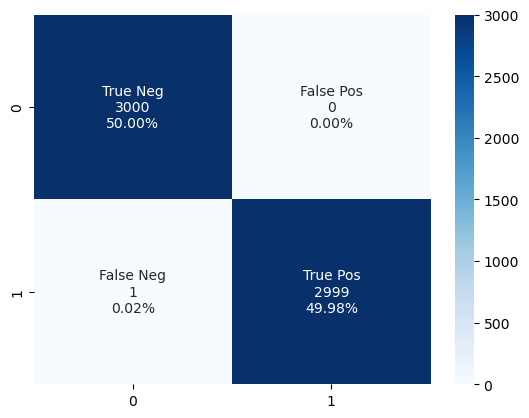

In [62]:

cms = confusion_matrix(Y,Y_cvpredlr)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cms.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms.flatten()/np.sum(cms)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cms, annot=labels, fmt='', cmap='Blues')

In [63]:
lr_auc = roc_auc_score(Y,Y_cvpredlr)
print('roc-auc score :{}'.format(lr_auc))

roc-auc score :0.9998333333333334


# # SVM

In [64]:
 import time

start_time = time.time()

# Your code goes here
sclassifier = SVC()
sclassifier.fit(x_train,y_train)

end_time = time.time()

print("Execution time:", end_time - start_time, "seconds")

Execution time: 0.022411346435546875 seconds


In [65]:
Y_preds = sclassifier.predict(x_test)
Y_cvpreds2 = cross_val_predict(sclassifier, X, Y, cv=10)
result(y_test,Y_preds)

Accuracy :  1.0
f1 score :  1.0
Precision :  1.0
recall :  1.0
MCC :  1.0
Cohen Kappa score :  1.0
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [66]:
cvresult(Y,Y_cvpreds2) #10 fold

Cross Val f1 score :  0.9996665555185061
Cross Val Precision :  1.0
Cross Val recall :  0.9993333333333333
MCC :  0.9993335554074814
Cohen Kappa score :  0.9993333333333333
Cross Val Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



<Axes: >

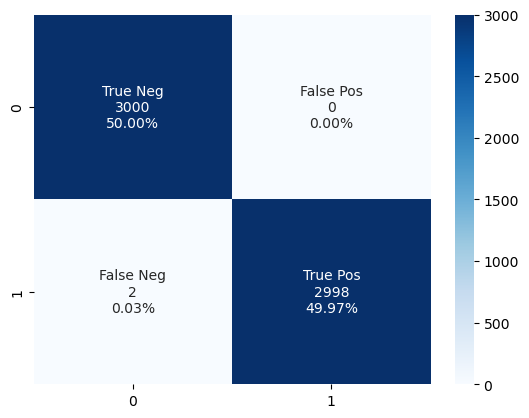

In [67]:
# 10 fold
cms = confusion_matrix(Y,Y_cvpreds2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cms.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms.flatten()/np.sum(cms)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cms, annot=labels, fmt='', cmap='Blues')

In [68]:
svm_auc = roc_auc_score(Y,Y_cvpreds2)
print('roc-auc score :{}'.format(svm_auc))

roc-auc score :0.9996666666666667


# # KNN

In [69]:
import time

start_time = time.time()

kclassifier = KNeighborsClassifier()
kclassifier.fit(x_train,y_train)

end_time = time.time()

print("Execution time:", end_time - start_time, "seconds")

Execution time: 0.010020971298217773 seconds


In [70]:
Y_predk = kclassifier.predict(x_test)
Y_cvpredk1 = cross_val_predict(kclassifier, X, Y, cv=10)
result(y_test,Y_predk)

Accuracy :  1.0
f1 score :  1.0
Precision :  1.0
recall :  1.0
MCC :  1.0
Cohen Kappa score :  1.0
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [71]:
cvresult(Y,Y_cvpredk1) #10 fold

Cross Val f1 score :  0.9998333055509252
Cross Val Precision :  1.0
Cross Val recall :  0.9996666666666667
MCC :  0.9996667222037082
Cohen Kappa score :  0.9996666666666667
Cross Val Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



<Axes: >

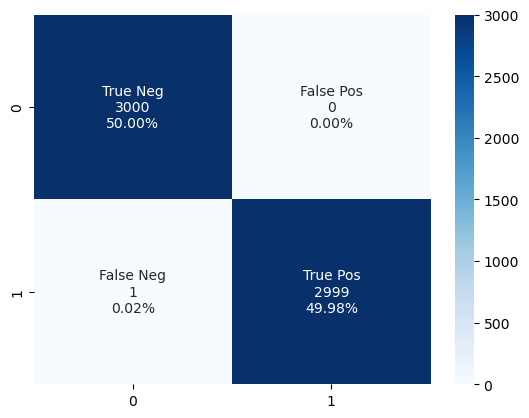

In [73]:
#10 fold
cmk = confusion_matrix(Y,Y_cvpredk1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cmk.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmk.flatten()/np.sum(cmk)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cmk, annot=labels, fmt='', cmap='Blues')

In [74]:
knn_auc = roc_auc_score(Y,Y_cvpredk1)
print('roc-auc score :{}'.format(knn_auc))

roc-auc score :0.9998333333333334


# # RF

In [75]:
import time

start_time = time.time()

rfclassifier = RandomForestClassifier()
rfclassifier.fit(x_train,y_train)

end_time = time.time()

print("Execution time:", end_time - start_time, "seconds")

Execution time: 0.36083126068115234 seconds


In [76]:
Y_predrf = rfclassifier.predict(x_test)
Y_cvpredrf1 = cross_val_predict(rfclassifier,X,Y,cv = 10) 
result(y_test,Y_predrf)

Accuracy :  1.0
f1 score :  1.0
Precision :  1.0
recall :  1.0
MCC :  1.0
Cohen Kappa score :  1.0
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [78]:
cvresult(Y,Y_cvpredrf1) #10 fold

Cross Val f1 score :  0.9998333055509252
Cross Val Precision :  1.0
Cross Val recall :  0.9996666666666667
MCC :  0.9996667222037082
Cohen Kappa score :  0.9996666666666667
Cross Val Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



<Axes: >

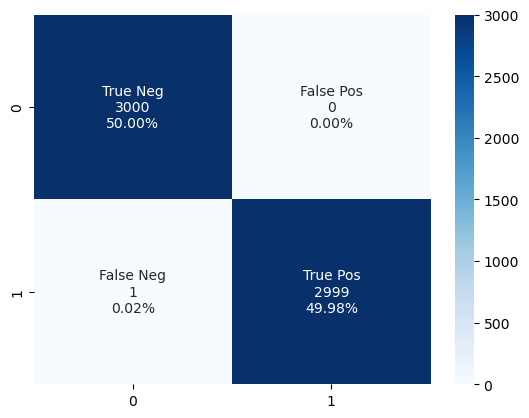

In [79]:
#10 fold
cvcmsrf = confusion_matrix(Y, Y_cvpredrf1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cvcmsrf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cvcmsrf.flatten()/np.sum(cvcmsrf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cvcmsrf, annot=labels, fmt='', cmap='Blues')

In [80]:
rf_auc = roc_auc_score(Y,Y_cvpredrf1)
print('roc-auc score :{}'.format(rf_auc))

roc-auc score :0.9998333333333334


# # DT

In [81]:
 import time

start_time = time.time()

# Your code goes here
dtclassifier = DecisionTreeClassifier()
dtclassifier.fit(x_train,y_train)

end_time = time.time()

print("Execution time:", end_time - start_time, "seconds")

Execution time: 0.00489497184753418 seconds


In [82]:
Y_preddt = dtclassifier.predict(x_test)
Y_cvpreddt = cross_val_predict(dtclassifier, X, Y, cv=10)
result(y_test,Y_preddt)

Accuracy :  1.0
f1 score :  1.0
Precision :  1.0
recall :  1.0
MCC :  1.0
Cohen Kappa score :  1.0
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [83]:
cvresult(Y,Y_cvpreddt) #5 fol

Cross Val f1 score :  0.9998333055509252
Cross Val Precision :  1.0
Cross Val recall :  0.9996666666666667
MCC :  0.9996667222037082
Cohen Kappa score :  0.9996666666666667
Cross Val Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



<Axes: >

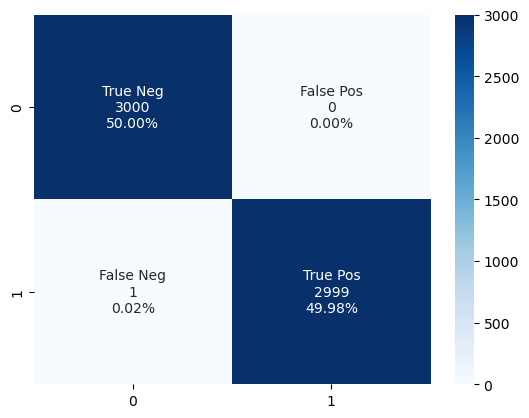

In [84]:
# 10 fold
cms = confusion_matrix(Y,Y_cvpreddt)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cms.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms.flatten()/np.sum(cms)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cms, annot=labels, fmt='', cmap='Blues')

In [85]:
dt_auc = roc_auc_score(Y,Y_cvpreddt)
print('roc-auc score :{}'.format(dt_auc))

roc-auc score :0.9998333333333334


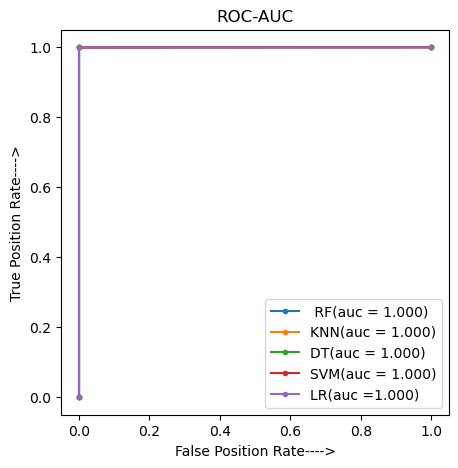

In [86]:
from sklearn.metrics import auc, roc_curve
logistic_fpr, logistic_tpr, threshold = roc_curve(Y, Y_cvpredlr) 
auc_logistic = auc(logistic_fpr, logistic_tpr)

dt_fpr, dt_tpr, threshold = roc_curve(Y, Y_cvpreddt)
auc_dt = auc(dt_fpr,dt_tpr)

svm_fpr, svm_tpr, threshold = roc_curve(Y, Y_cvpreds2)
auc_svm = auc(svm_fpr, svm_tpr)

ran_fpr, ran_tpr, threshold = roc_curve(Y, Y_cvpredrf1)
auc_ran = auc(ran_fpr,ran_tpr)

knn_fpr, knn_tpr, threshold = roc_curve(Y, Y_cvpredk1)
auc_knn = auc(knn_fpr,knn_tpr)


plt.figure(figsize=(5,5), dpi = 100)
plt.plot(ran_fpr,ran_tpr, marker = '.',label = ' RF(auc = %0.3f)' %auc_ran)
plt.plot(knn_fpr, knn_tpr, marker = '.', label = 'KNN(auc = %0.3f)'%auc_knn)
plt.plot(dt_fpr, dt_tpr, marker = '.',label = 'DT(auc = %0.3f)' %auc_dt)
plt.plot(svm_fpr, svm_tpr, marker= '.', label = 'SVM(auc = %0.3f)' % auc_svm)
plt.plot(logistic_fpr,logistic_tpr, marker='.', label = 'LR(auc =%0.3f)' %auc_logistic)

plt.title('ROC-AUC')
plt.xlabel('False Position Rate---->')
plt.ylabel('True Position Rate---->')

plt.legend()
plt.savefig("roc.png")

plt.show()

